In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten

In [3]:
df = pd.read_csv("/content/BTC-USD.csv")

In [4]:
# Kiểm tra dữ liệu
print(df.head())
print(df.info())

         Date         Open         High          Low        Close  \
0  2019-03-01  3853.757080  3907.795410  3851.692383  3859.583740   
1  2019-03-02  3855.318115  3874.607422  3832.127930  3864.415039   
2  2019-03-03  3862.266113  3875.483643  3836.905762  3847.175781   
3  2019-03-04  3845.091553  3867.381836  3733.749756  3761.557129   
4  2019-03-05  3759.832520  3903.916748  3745.183105  3896.375000   

     Adj Close       Volume  
0  3859.583740   7661247975  
1  3864.415039   7578786076  
2  3847.175781   7253558152  
3  3761.557129   9029175788  
4  3896.375000  10174126415  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1920 non-null   object 
 1   Open       1920 non-null   float64
 2   High       1920 non-null   float64
 3   Low        1920 non-null   float64
 4   Close      1920 non-null   float64
 5   Adj Close  192

In [5]:
# Sử dụng cột 'Close' làm dữ liệu để dự đoán
df1 = df['Close'].values.reshape(-1, 1)

In [6]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
df1 = scaler.fit_transform(df1)

In [7]:
# Chia dữ liệu thành tập train và test
train_size = int(0.7 * len(df1))
test_size = len(df1) - train_size
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]

In [8]:
# Kiểm tra kích thước của tập train và test
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [9]:
# Hàm tạo dataset từ chuỗi dữ liệu
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
# Tạo các tập X và Y từ dữ liệu train và test
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [11]:
# Định hình lại dữ liệu để phù hợp với đầu vào của TimesNet
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [12]:
# Xây dựng mô hình TimesNet
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(time_step, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1)

Epoch 1/100
20/20 [==============================] - 1s 11ms/step - loss: 0.0359
Epoch 2/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0044
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0021
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0020
Epoch 5/100
20/20 [==============================] - 0s 25ms/step - loss: 0.0015
Epoch 6/100
20/20 [==============================] - 0s 22ms/step - loss: 0.0014
Epoch 7/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0014
Epoch 8/100
20/20 [==============================] - 0s 12ms/step - loss: 0.0012
Epoch 9/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 10/100
20/20 [==============================] - 0s 20ms/step - loss: 0.0011
Epoch 11/100
20/20 [==============================] - 0s 18ms/step - loss: 0.0012
Epoch 12/100
20/20 [==============================] - 0s 10ms/step - loss: 0.0012
Epoch 13/100
20/20 [======

In [14]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

15/15 [==============================] - 0s 3ms/step


In [15]:
# Chuyển đổi giá trị về phạm vi gốc
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [16]:
# Đánh giá mô hình
train_rmse = np.sqrt(np.mean((train_predict - y_train)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test)**2))
test_mape = np.mean(np.abs((y_test - test_predict) / y_test)) * 100
test_mse = np.mean((y_test - test_predict)**2)

print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)
print('Test MAPE:', test_mape)
print('Test MSE:', test_mse)

Train RMSE: 1255.066889088881
Test RMSE: 1257.588281904418
Test MAPE: 2.2381952241931238
Test MSE: 1581528.286783306


In [17]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.67756889 0.68967404 0.69201294 0.73224787 0.76921984 0.84739737
 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461 0.86609866
 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915 0.98615743
 0.97688739 1.         0.97566562 0.9469183  0.88793761 0.93230318
 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499 0.86986376
 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542 0.95397313
 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056 0.93400854
 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905 0.96399961
 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929 0.8662525
 0.82968151 0.86193771 0.86670989 0.88331172 0.88233372 0.90990125
 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873  0.85617441
 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184 0.8674009
 0.86941556 0.8568772  0.84494544 0.82840125 0.85526172 0.82270083
 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604 0.88673257
 0.91299111 0.91138888 0.90183292 0.97641    0.95748

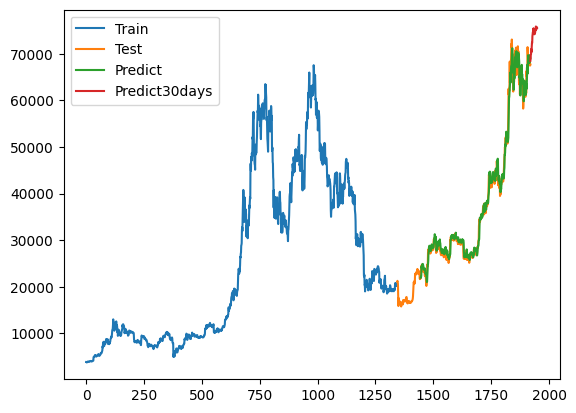

In [18]:
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(test_predict))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [19]:
x_input.shape

(1, 100, 1)

In [20]:
train_size_82 = int(0.8 * len(df1))
test_size_82 = len(df1) - train_size_82
train_data_82 = df1[:train_size_82]
test_data_82 = df1[train_size_82:train_size_82+test_size_82]

In [21]:
X_train_82, y_train_82 = create_dataset(train_data_82, time_step)
X_test_82, ytest_82 = create_dataset(test_data_82, time_step)

In [22]:
X_train_82 =X_train_82.reshape(X_train_82.shape[0],X_train_82.shape[1] , 1)
X_test_82 = X_test_82.reshape(X_test_82.shape[0],X_test_82.shape[1] , 1)

In [23]:
model.fit(X_train_82,y_train_82,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
23/23 [==============================] - 0s 10ms/step - loss: 3.5182e-04
Epoch 2/100
23/23 [==============================] - 0s 11ms/step - loss: 5.1678e-04
Epoch 3/100
23/23 [==============================] - 0s 10ms/step - loss: 4.0721e-04
Epoch 4/100
23/23 [==============================] - 0s 10ms/step - loss: 3.5963e-04
Epoch 5/100
23/23 [==============================] - 0s 10ms/step - loss: 3.9672e-04
Epoch 6/100
23/23 [==============================] - 0s 12ms/step - loss: 2.6565e-04
Epoch 7/100
23/23 [==============================] - 0s 10ms/step - loss: 5.7381e-04
Epoch 8/100
23/23 [==============================] - 0s 9ms/step - loss: 5.4932e-04
Epoch 9/100
23/23 [==============================] - 0s 9ms/step - loss: 5.2734e-04
Epoch 10/100
23/23 [==============================] - 0s 12ms/step - loss: 3.5285e-04
Epoch 11/100
23/23 [==============================] - 0s 10ms/step - loss: 3.1016e-04
Epoch 12/100
23/23 [==============================] - 0s 10ms/ste

In [25]:
train_predict_82 = model.predict(X_train_82)
test_predict_82 = model.predict(X_test_82)

9/9 [==============================] - 0s 3ms/step


In [26]:
train_predict_82 = scaler.inverse_transform(train_predict_82)
test_predict_82 = scaler.inverse_transform(test_predict_82)
y_train_82 = scaler.inverse_transform(y_train_82.reshape(-1, 1))
ytest_82 = scaler.inverse_transform(ytest_82.reshape(-1, 1))

In [27]:
train_82_rmse = np.sqrt(np.mean((train_predict_82 - y_train_82)**2))
test_82_rmse = np.sqrt(np.mean((test_predict_82 - ytest_82)**2))
test_82_mape = np.mean(np.abs((ytest_82 - test_predict_82) / ytest_82)) * 100
test_82_mse = np.mean((ytest_82 - test_predict_82)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 1285.8142606956146
Test RMSE: 2419.401913188432
Test MAPE: 3.564584738348333
Test MSE: 5853505.6175398445


In [28]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_82[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.67756889 0.68967404 0.69201294 0.73224787 0.76921984 0.84739737
 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461 0.86609866
 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915 0.98615743
 0.97688739 1.         0.97566562 0.9469183  0.88793761 0.93230318
 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499 0.86986376
 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542 0.95397313
 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056 0.93400854
 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905 0.96399961
 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929 0.8662525
 0.82968151 0.86193771 0.86670989 0.88331172 0.88233372 0.90990125
 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873  0.85617441
 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184 0.8674009
 0.86941556 0.8568772  0.84494544 0.82840125 0.85526172 0.82270083
 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604 0.88673257
 0.91299111 0.91138888 0.90183292 0.97641    0.95748

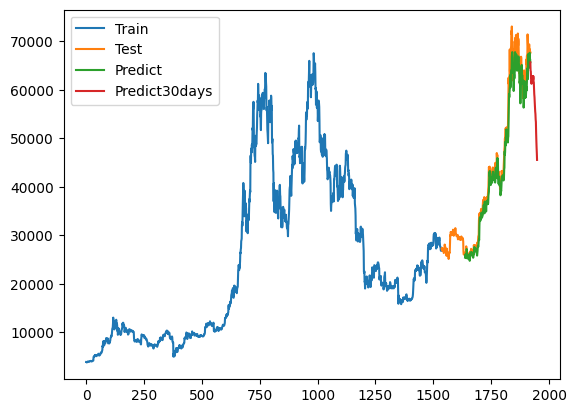

In [29]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_82, step=1)
plt.plot(scaler.inverse_transform(train_data_82))
test_data_index = pd.RangeIndex(start=train_size_82, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_82))
test_data_index = pd.RangeIndex(start=train_size_82+101, stop=train_size_82+test_size_82, step=1)
plt.plot(test_data_index,(test_predict_82))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()

In [30]:
train_size_91 = int(0.9 * len(df1))
test_size_91 = len(df1) - train_size_91
train_data_91 = df1[:train_size_91]
test_data_91 = df1[train_size_91:train_size_91+test_size_91]

In [31]:
X_train_91, y_train_91 = create_dataset(train_data_91, time_step)
X_test_91, ytest_91 = create_dataset(test_data_91, time_step)

In [32]:
X_train_91 =X_train_91.reshape(X_train_91.shape[0],X_train_91.shape[1] , 1)
X_test_91 = X_test_91.reshape(X_test_91.shape[0],X_test_91.shape[1] , 1)

In [33]:
model.fit(X_train_91,y_train_91,epochs=100,batch_size=64,verbose=1)

Epoch 1/100
26/26 [==============================] - 0s 11ms/step - loss: 2.9162e-04
Epoch 2/100
26/26 [==============================] - 0s 11ms/step - loss: 2.9327e-04
Epoch 3/100
26/26 [==============================] - 0s 10ms/step - loss: 2.3318e-04
Epoch 4/100
26/26 [==============================] - 0s 10ms/step - loss: 2.3081e-04
Epoch 5/100
26/26 [==============================] - 0s 16ms/step - loss: 2.8627e-04
Epoch 6/100
26/26 [==============================] - 0s 16ms/step - loss: 2.2894e-04
Epoch 7/100
26/26 [==============================] - 0s 16ms/step - loss: 2.6024e-04
Epoch 8/100
26/26 [==============================] - 0s 17ms/step - loss: 2.7810e-04
Epoch 9/100
26/26 [==============================] - 0s 16ms/step - loss: 3.1515e-04
Epoch 10/100
26/26 [==============================] - 0s 16ms/step - loss: 3.1545e-04
Epoch 11/100
26/26 [==============================] - 0s 16ms/step - loss: 3.2098e-04
Epoch 12/100
26/26 [==============================] - 0s 16ms/s

In [34]:
train_predict_91 = model.predict(X_train_91)
test_predict_91 = model.predict(X_test_91)

3/3 [==============================] - 0s 5ms/step


In [35]:
train_predict_91 = scaler.inverse_transform(train_predict_91)
test_predict_91 = scaler.inverse_transform(test_predict_91)
y_train_91 = scaler.inverse_transform(y_train_91.reshape(-1, 1))
ytest_91 = scaler.inverse_transform(ytest_91.reshape(-1, 1))

In [36]:
train_91_rmse = np.sqrt(np.mean((train_predict_91 - y_train_91)**2))
test_91_rmse = np.sqrt(np.mean((test_predict_91 - ytest_91)**2))
test_91_mape = np.mean(np.abs((ytest_91 - test_predict_91) / ytest_91)) * 100
test_91_mse = np.mean((ytest_91 - test_predict_91)**2)

print('Train RMSE:', train_82_rmse)
print('Test RMSE:', test_82_rmse)
print('Test MAPE:', test_82_mape)
print('Test MSE:', test_82_mse)

Train RMSE: 1285.8142606956146
Test RMSE: 2419.401913188432
Test MAPE: 3.564584738348333
Test MSE: 5853505.6175398445


In [37]:
# Dự đoán 30 ngày tiếp theo và in ra màn hình
x_input = test_data_91[-101:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

from numpy import array

lst_output = []
n_steps = 100
i = 0
while i < 30:

    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.67756889 0.68967404 0.69201294 0.73224787 0.76921984 0.84739737
 0.82855187 0.84647189 0.84054613 0.85695541 0.93143461 0.86609866
 0.89935805 0.91116787 0.93099723 0.93386485 0.94137915 0.98615743
 0.97688739 1.         0.97566562 0.9469183  0.88793761 0.93230318
 0.9201565  0.83885728 0.92542292 0.89048043 0.86577499 0.86986376
 0.91562083 0.95492499 0.95534366 0.94766222 0.96626542 0.95397313
 0.9504025  0.97475761 0.95122249 0.88983968 0.89754056 0.93400854
 0.92432613 0.93959502 0.9463237  0.97905222 0.94309905 0.96399961
 0.95639345 0.91506827 0.86639112 0.89404836 0.86068929 0.8662525
 0.82968151 0.86193771 0.86670989 0.88331172 0.88233372 0.90990125
 0.90369245 0.87296084 0.87591529 0.86543684 0.8605873  0.85617441
 0.86667455 0.82045159 0.78607801 0.7986198  0.85295184 0.8674009
 0.86941556 0.8568772  0.84494544 0.82840125 0.85526172 0.82270083
 0.8227143  0.8321584  0.85311937 0.83366434 0.90167604 0.88673257
 0.91299111 0.91138888 0.90183292 0.97641    0.95748

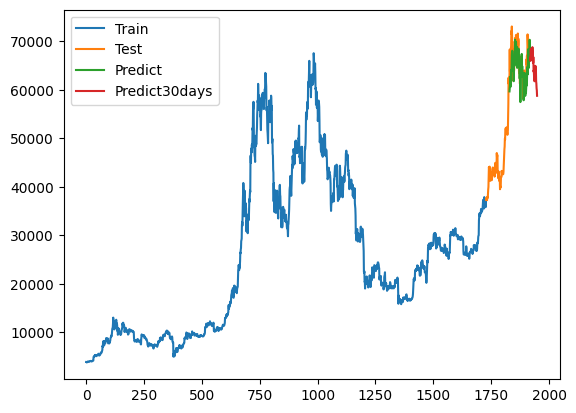

In [38]:
train_data_index = pd.RangeIndex(start=0, stop=train_size_91, step=1)
plt.plot(scaler.inverse_transform(train_data_91))
test_data_index = pd.RangeIndex(start=train_size_91, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data_91))
test_data_index = pd.RangeIndex(start=train_size_91+101, stop=train_size_91+test_size_91, step=1)
plt.plot(test_data_index,(test_predict_91))
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict30days'])
plt.show()